## Imageloading + Thresholding + Measurement

You can use the  ```glob``` module to get a list of all matching filepaths in a folder. The ```*``` symbol tells glob to consider all possibilities, and thus glob will find all .tif files with arbitrary filename in the given folder path.

In [2]:
from glob import glob

filepaths = glob('./data/*.tif')

filepaths

['./data/IXMtest_A18_s6_w17AEEB754-2604-4D00-9879-76EF073B7202.tif',
 './data/segmentation_nuclei.tif',
 './data/Hoechst_C21_08.tif',
 './data/Hoechst_C21_06.tif',
 './data/nuclei_lamin_002.tif',
 './data/Hoechst_D21_01.tif',
 './data/IXMtest_A18_s2_w1BB7E78F9-CC00-4654-9AF4-F24FBA20E630.tif',
 './data/IXMtest_A18_s1_w1BFDF1C94-9C1F-4F5F-BBC1-05196333B1BF.tif',
 './data/Hoechst_D21_00.tif',
 './data/Hoechst_C21_01.tif',
 './data/Hoechst_C21_07.tif',
 './data/segmentation_mask_gt.tif',
 './data/IXMtest_A18_s5_w18504E02A-DE75-460B-BD1A-3001AC0DD626.tif',
 './data/Hoechst_C21_00.tif',
 './data/Hoechst_D21_06.tif',
 './data/Hoechst_D21_08.tif',
 './data/nuclei_crop.tif',
 './data/IXMtest_A17_s9_w11BD1E0C1-B400-44F3-B4B8-9335F645310E.tif',
 './data/nuclei_dapi_002.tif',
 './data/Hoechst_D21_03.tif',
 './data/Hoechst_C21_02.tif',
 './data/IXMtest_A18_s3_w1737EE06A-26D0-413B-9C92-C24152DD4750.tif',
 './data/Hoechst_D21_04.tif',
 './data/Hoechst_C21_05.tif',
 './data/IXMtest_A18_s4_w1830F3981-

There are images from two different datasets mixed together in the folder. Separate them and only load the *Hoechst_\** images.

* Load all *Hoechst_\** images in ```filepaths``` and put them into a list ```images```:

In [3]:
from skimage.io import imread


images_path = [s for s in filepaths if "Hoechst_" in s]
images = [imread(image) for image in images_path]

* Try Otsu Thresholding on one of the loaded images:

4095


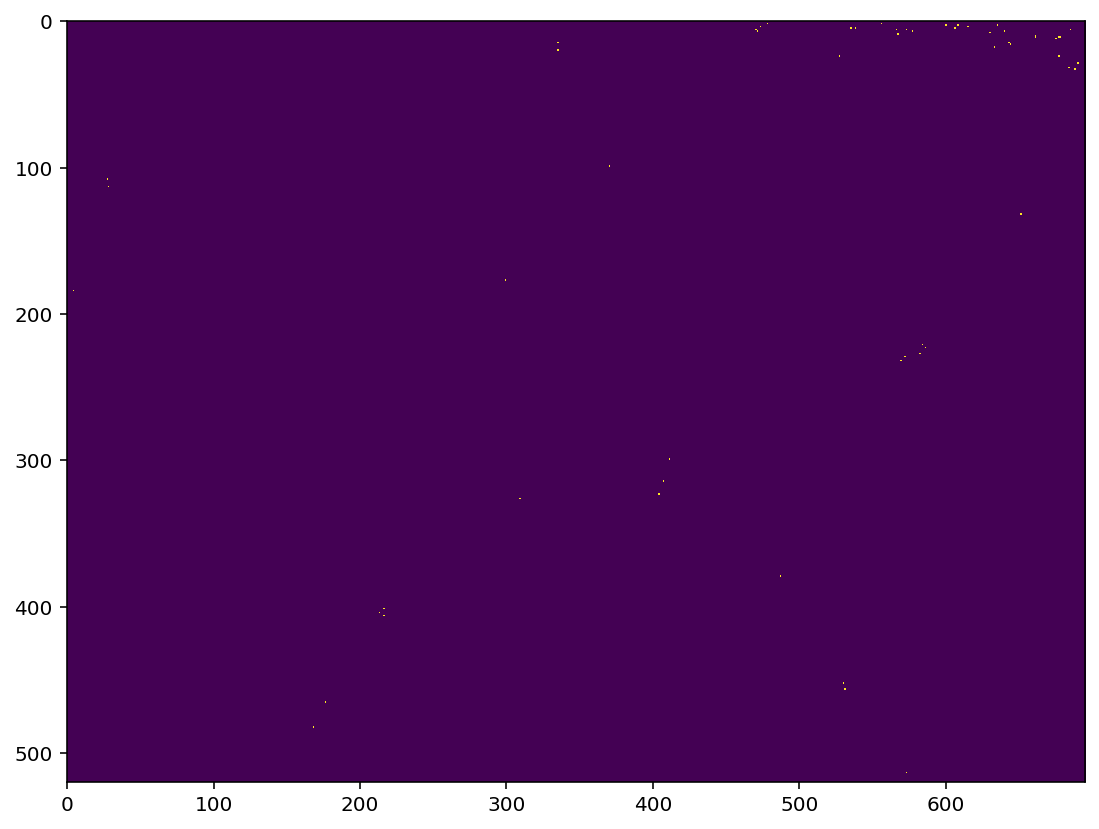

In [4]:
from skimage.filters import threshold_otsu
from matplotlib import pyplot as plt


threshold = threshold_otsu(images[1])

print(threshold)
otsu_thresholded_image = images[1] > threshold

# Maybe side by side comparison here
plt.imshow(otsu_thresholded_image)

* Try all other thresholding algorithms to see if we can find one that is better:

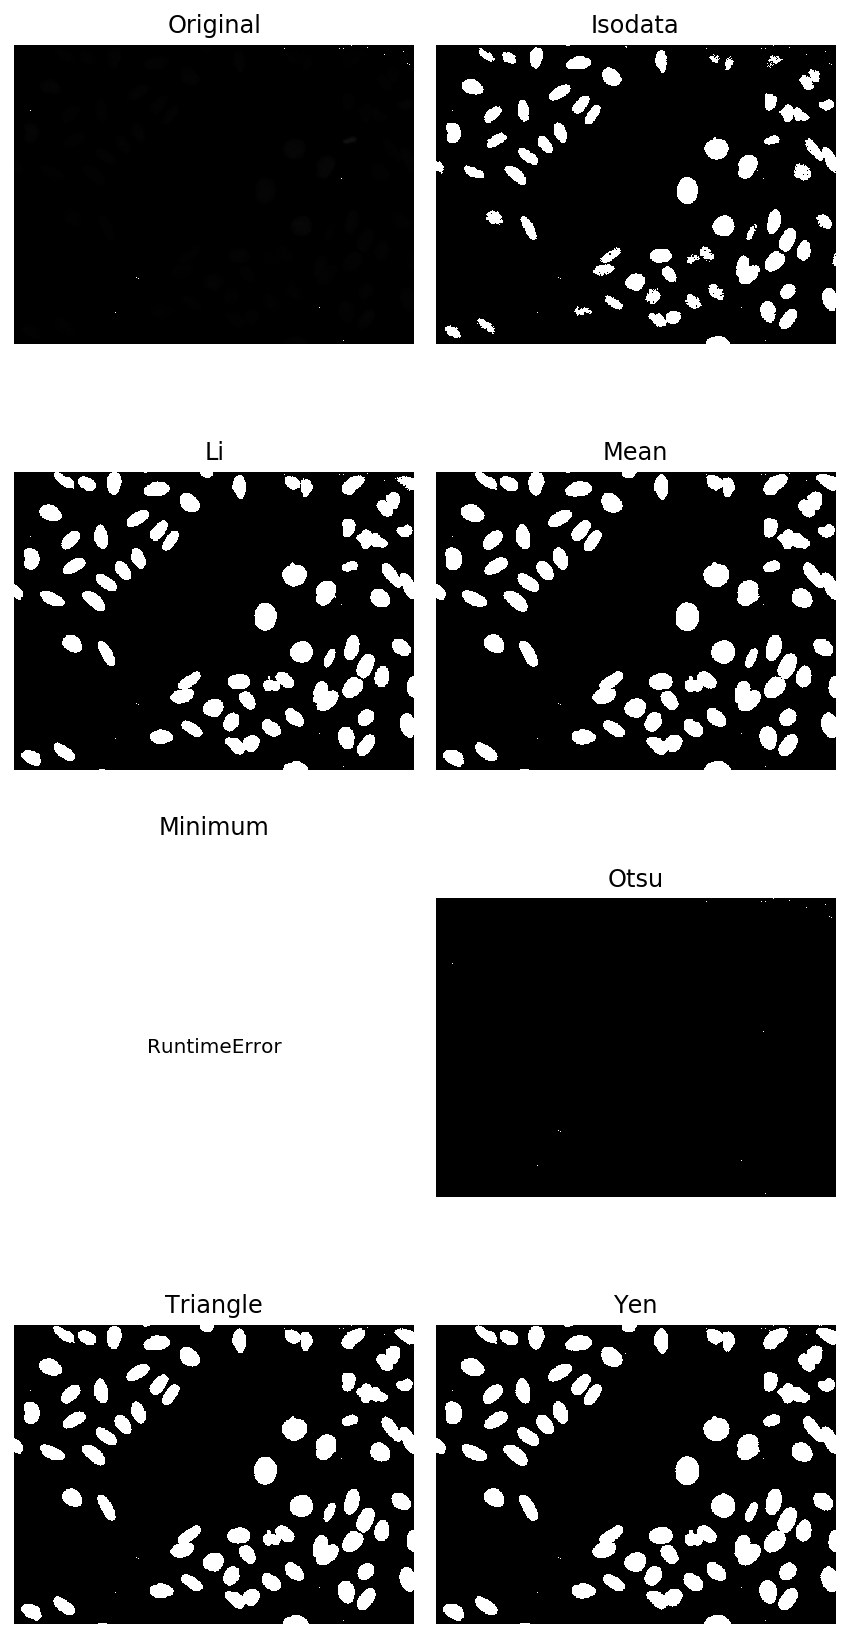

In [5]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(images[1], figsize=(6, 12), verbose=False)
plt.show()
#Isodata, Li, Mean, triangle, Yen have good performance for the images[1]

**The reason Otsu thresholding does not work for these images is because they have *hot pixels* (with intensity 65535) in them. *Hot pixels* are caused by broken sensor elements and can be quite common in old cameras. They might not matter much to us if we look at the images, but a simple tresholding algorithm can be thrown off by them. It is always good to look at the results of you segmentation to make sure an automated procedure actually computed something reasonable!**

* Choose a good Segmentation algorithm of the above and create a list of segmented masks for all *Hoechst_\** images. 

You can find the exact function names you need to import either by googling ``` skimage filters ``` (the submodule that also threshold_otsu is in) or under this link next to threshold_otsu:

https://scikit-image.org/docs/dev/api/skimage.filters.html



In [6]:
from skimage.filters import threshold_mean

mean_thresholded_images = []
for image in images:
    threshold = threshold_mean(image)
    mean_thresholded_image = image > threshold
    mean_thresholded_images.append(mean_thresholded_image)

* Try to get the mean intensity of the nuclei in each *Hoechst_\** image and print them.

You have to use the segmented masks you created above and use them as binary masks

In [7]:
mean_intensity = []
for num in range(0,len(images)):
    mean_intensity.append(images[num][mean_thresholded_images[num]].mean())
print(mean_intensity)

[780.2341986096052, 809.3222942164626, 776.7730218281037, 790.9806025588114, 833.1525976872643, 817.6958537702646, 895.3445201289748, 818.3901839629266, 749.7687913512038, 797.399798257361, 792.6142940341426, 785.3364741943266, 923.2394268929384, 817.0000104007405, 770.9746046256513, 819.4152769482856, 782.9578548315462, 796.3104900920222]


* The mean intensities are pretty similar for all images, but the images all have different background intensities that we have to account for.

Take the mean intensities of above and subtract each value with the mean intensity of the respective background. Then print the mean intensities again.

Tip: Inverting your segmentation of the nuclei yields a mask for the background.

**It is almost always a good idea to subtract background intensities if you want to perform quantativie measurements in images!**



In [8]:
new_mean_intensity = []
for num in range(0,len(images)):
    new_mean_intensity.append(images[num][mean_thresholded_images[num]].mean()-images[num][mean_thresholded_images[num]!=True].mean())
print(new_mean_intensity)

[597.4418029792803, 641.0086919607295, 472.3345400849678, 481.99432267253854, 644.2868086094269, 640.2854755633246, 706.2049924287332, 516.6038126652204, 443.5483584781773, 493.58665461746756, 597.961906204219, 484.5360343262184, 729.2051578487687, 640.1747271703146, 467.0297043082943, 514.8381696153097, 474.9127826276891, 616.4461243493477]


c) If you look at the file names of the Hoechst* images, you can see that they actually correspond to two different wells in a multiwell experiment (C21 and D21).
Split the mean values you just calculated according the the well of the image file and print them.

**Bonus:** you could even collect the values in 2 lists and do a statistical test to see if they differ significantly. For example, you could run ```from scipy.stats import ttest_ind``` to get a function ```ttest_ind``` that performs a t-test.



In [9]:
C21_images_path = [s for s in filepaths if "Hoechst_C21" in s]
C21_images = [imread(image) for image in C21_images_path]
D21_images_path = [s for s in filepaths if "Hoechst_D21" in s]
D21_images = [imread(image) for image in D21_images_path]

C21_mean_thresholded_images = []
for image in C21_images:
    threshold = threshold_mean(image)
    mean_thresholded_image = image > threshold
    C21_mean_thresholded_images.append(mean_thresholded_image)

D21_mean_thresholded_images = []
for image in D21_images:
    threshold = threshold_mean(image)
    mean_thresholded_image = image > threshold
    D21_mean_thresholded_images.append(mean_thresholded_image)

C21_mean_intensity = []
for num in range(0,len(C21_images)):
    C21_mean_intensity.append(C21_images[num][C21_mean_thresholded_images[num]].mean()-C21_images[num][C21_mean_thresholded_images[num]!=True].mean())
print(C21_mean_intensity)

D21_mean_intensity = []
for num in range(0,len(D21_images)):
    D21_mean_intensity.append(D21_images[num][D21_mean_thresholded_images[num]].mean()-D21_images[num][D21_mean_thresholded_images[num]!=True].mean())
print(D21_mean_intensity)

from scipy.stats import ttest_ind

ttest_ind(D21_mean_intensity, C21_mean_intensity)
#Seems the p-value is lower than 0.05, it is significantly different

[597.4418029792803, 641.0086919607295, 644.2868086094269, 640.2854755633246, 706.2049924287332, 597.961906204219, 729.2051578487687, 640.1747271703146, 616.4461243493477]
[472.3345400849678, 481.99432267253854, 516.6038126652204, 443.5483584781773, 493.58665461746756, 484.5360343262184, 467.0297043082943, 514.8381696153097, 474.9127826276891]


Ttest_indResult(statistic=-9.654452581820923, pvalue=4.470447117688589e-08)

## Task Z Planes

a) Load the 3d image stack in file "./data/dapi_stack.tif"

In [10]:
from skimage.io import imread

stack = imread('/projects/616bebf1-83bb-4da8-a0be-bad824c72dfe/handouts/day3/data/dapi_stack.tif')

b) Go through all z-planes in the stack and save them as individual files (Make sure to use different filenames for each plane, e.g. you could add the z-index to the filename)

In [11]:
from skimage.io import imsave

len(stack)
for num in range(0, len(stack)):
    imsave(str(num) + "_dapi.tif", stack[num])

## Tasks on Morphological Operations and binary images

Morphological operations provide a way of extracting a variety of measurements from your images, if you combine them in a clever way.

In the following tasks, you can try it yourself on three examples:

### Measuring the circumference of a cell

* Load the image ```'data/nuclei_crop.tif'``` and plot it

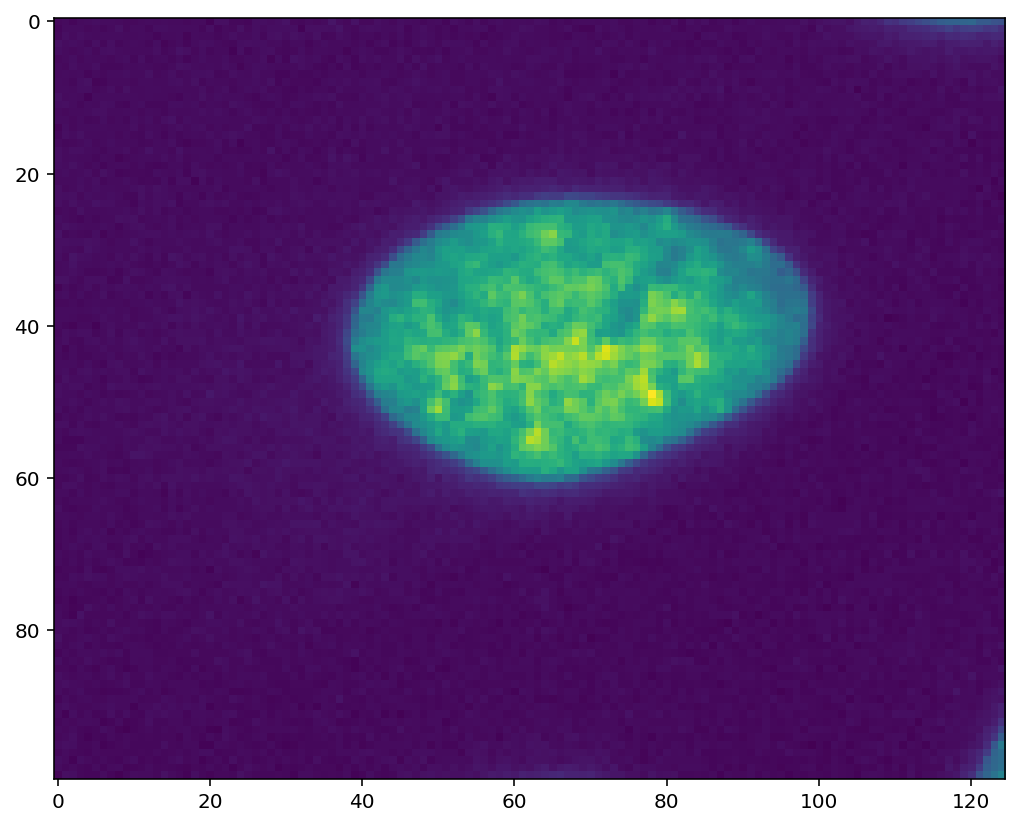

In [12]:
crop_image = imread('data/nuclei_crop.tif')
plt.figure()
plt.imshow(crop_image)

* Segment the cell (create a binary mask) in the image using thresholding

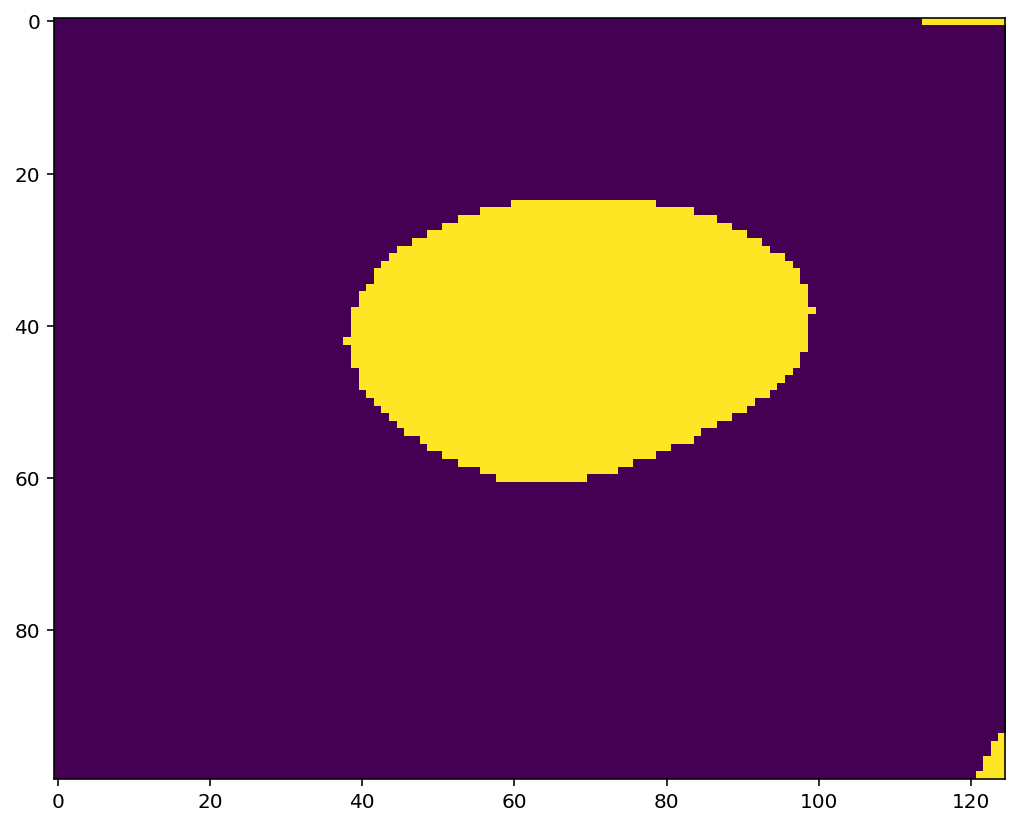

In [13]:
thresholded_image = crop_image > 300
plt.imshow(thresholded_image)

* Use binary erosion to create a version of the mask that is shrunk by 1 pixel

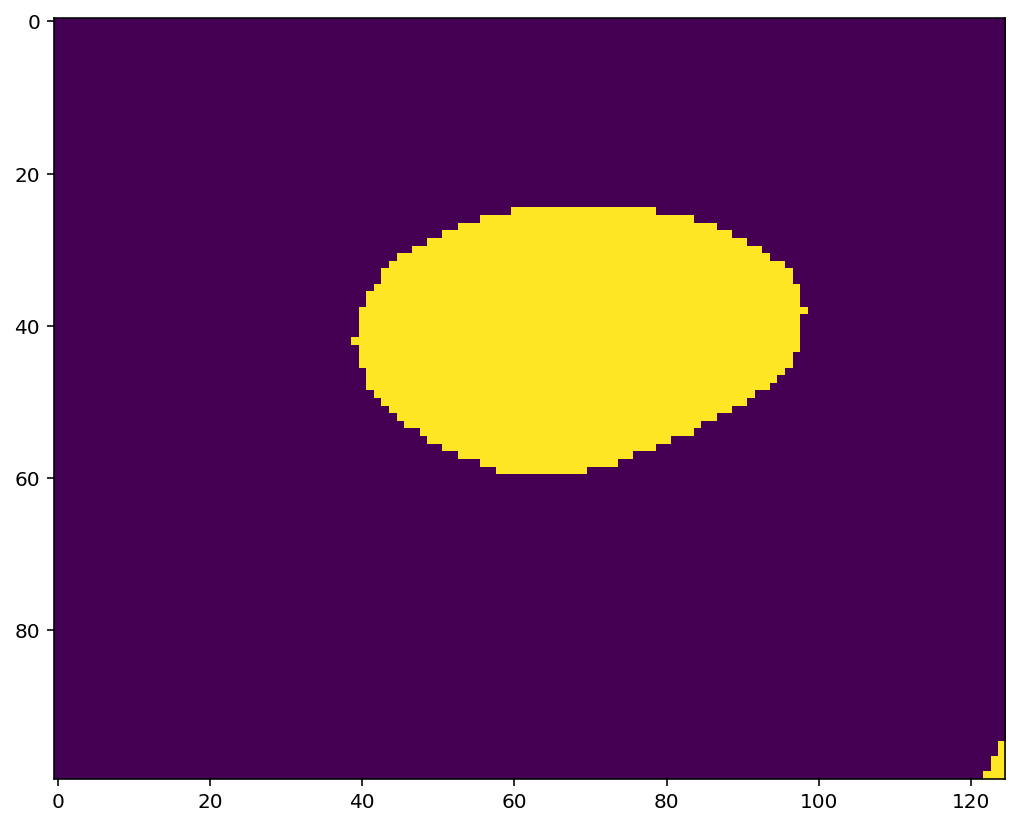

In [14]:
from skimage.morphology import binary_erosion

eroded_mask = binary_erosion(thresholded_image)

plt.imshow(eroded_mask)

- `Calculate the exclusive OR (^ operator) of the original and eroded mask and display it - it should be just a ring corresponding to the outline of the cell`



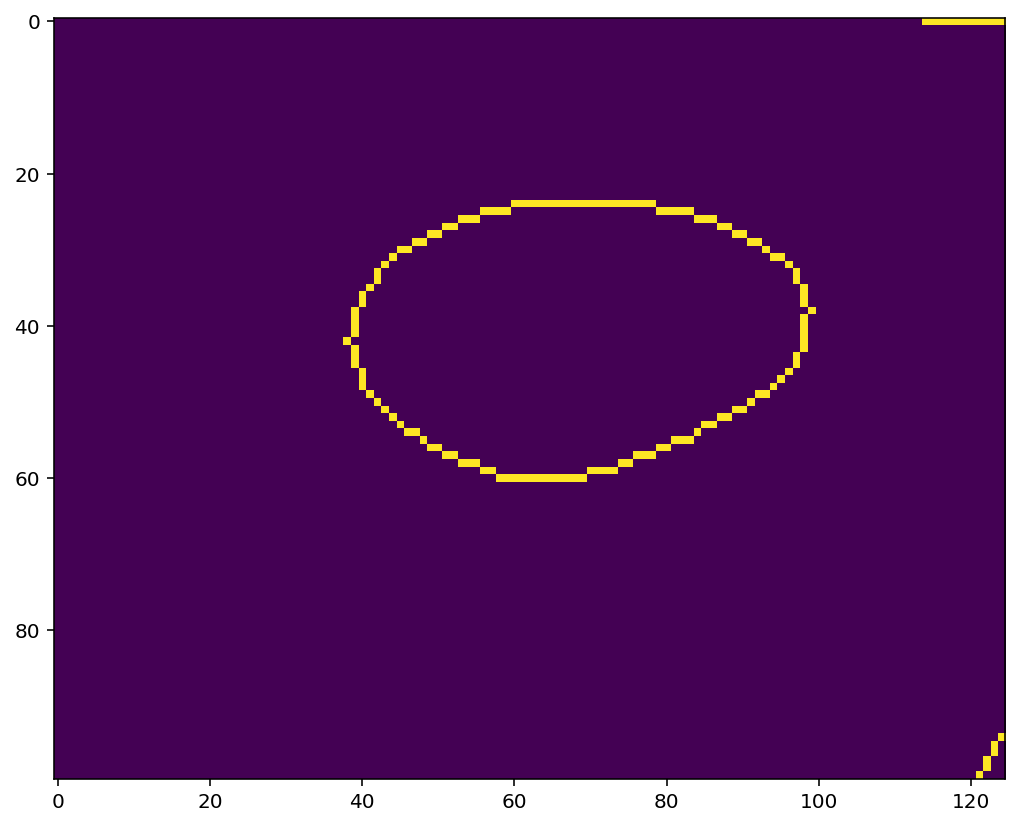

In [15]:
plt.imshow(thresholded_image ^ eroded_mask)

* Sum up the pixels in your outline mask - *this corresponds to the length of the outline, i.e. the circumference of the cell*

In [16]:
exclusive_or = thresholded_image ^ eroded_mask
exclusive_or.sum()

156

### Measuring signal at just the border of cells

We can use a similar strategy to measure intensity in a separate channel at just the border of cells.

We will be using DAPI stained nuclei to segment the nuclei and a *simulated* Lamin channel in which we want to do our measurements:

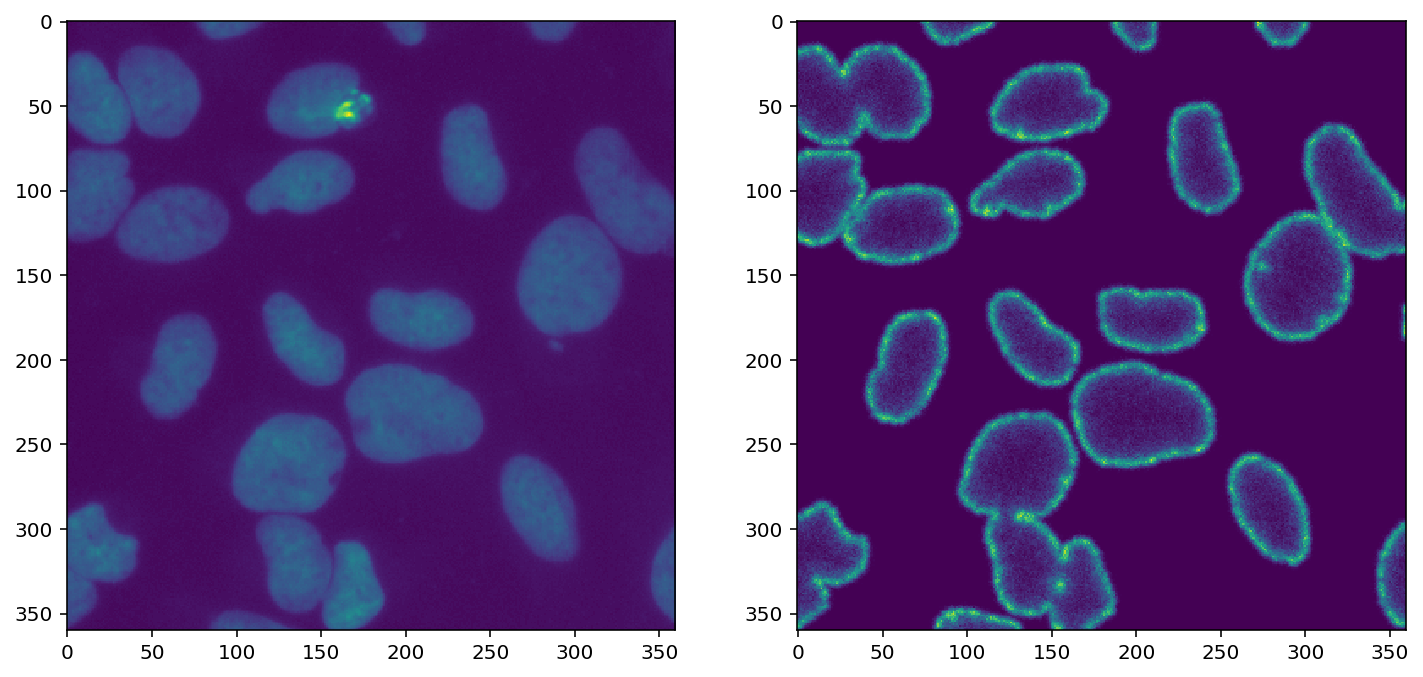

In [17]:
from skimage.io import imread
from matplotlib import pyplot as plt

img_dapi = imread('data/nuclei_dapi_002.tif')
img_fluo = imread('data/nuclei_lamin_002.tif')

fig, axs = plt.subplots(ncols=2)
axs[0].imshow(img_dapi)
axs[1].imshow(img_fluo)

* create a mask of the cells from the DAPI image using thresholding

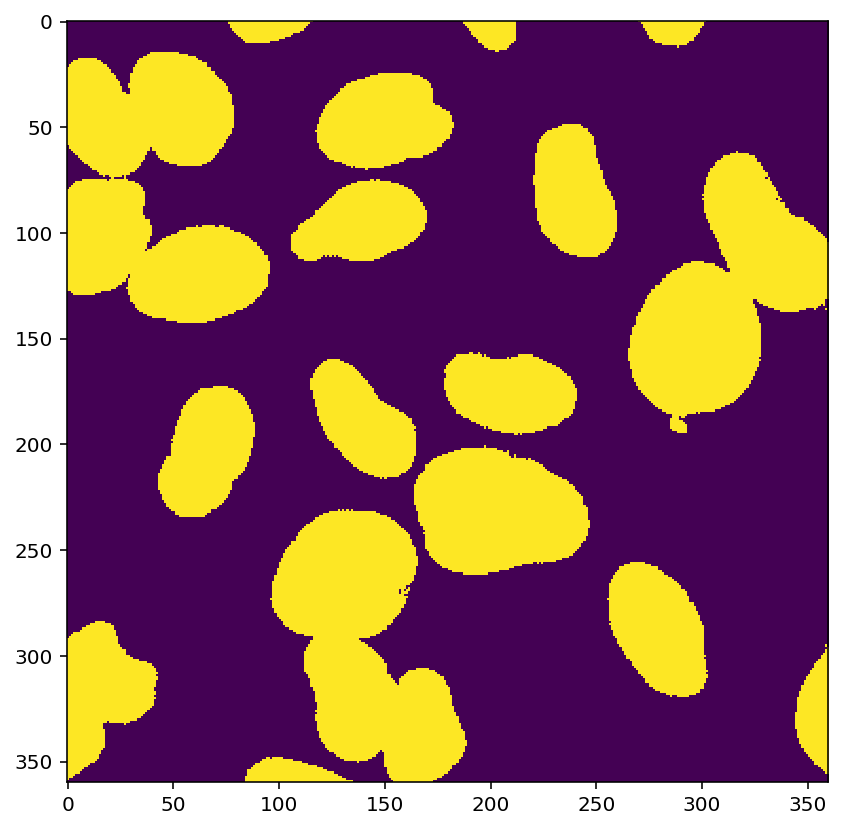

In [18]:
threshold_img_dapi = img_dapi > img_dapi.mean()
plt.imshow(threshold_img_dapi)

* use erosion to shrink the mask by 5 pixels and calculate the XOR with the original mask



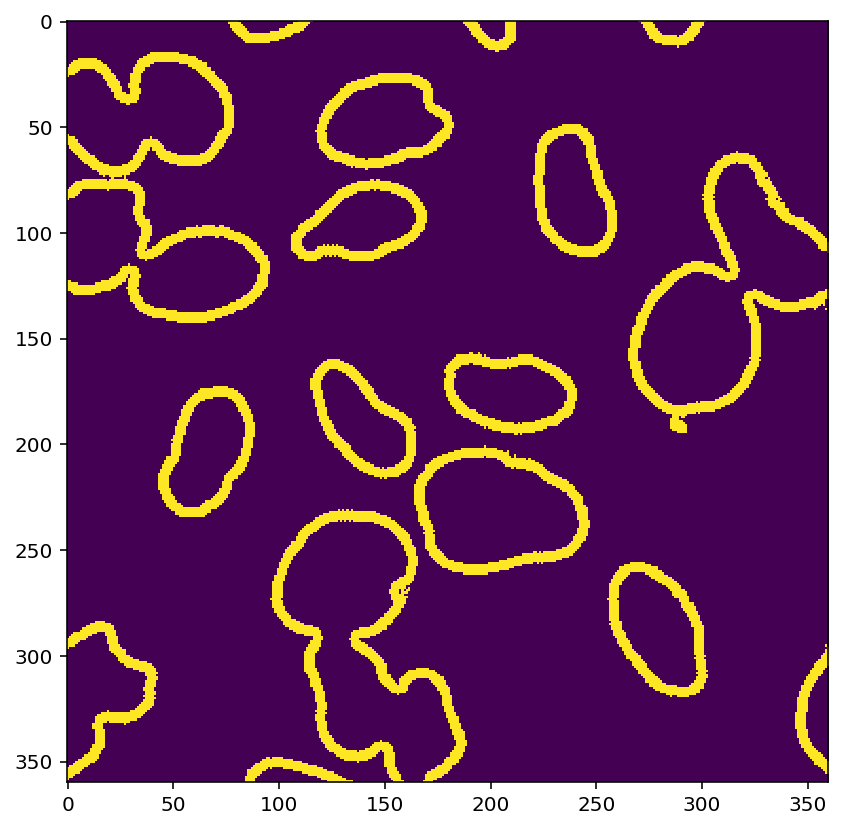

In [19]:
from skimage.morphology import disk

disk(5)
eroded_mask = binary_erosion(threshold_img_dapi, disk(5))

plt.imshow(threshold_img_dapi ^ eroded_mask)

- use the mask of the border to index into `img_fluo` and measure the mean intensity on the nuclear border
- use the eroded mask to  
   measure the mean intensity of `img_fluo` in the interior of nuclei



In [20]:
border = threshold_img_dapi ^ eroded_mask
border_mean_intensity = img_fluo[border].mean()
print("The mean intensity on the nuclear border: "+ str(border_mean_intensity))

eroded_mask = binary_erosion(img_fluo)
mean_intensity = (img_fluo[eroded_mask]).mean()
print("The mean intensity in the interior of nuclei: "+ str(mean_intensity))

The mean intensity on the nuclear border: 44.34839160839161
The mean intensity in the interior of nuclei: 24.522833678716708


* calculate the ratio of fluorecense at the border and in the center

In [21]:
ratio = border_mean_intensity/mean_intensity
print(ratio)

1.808452978534917


### Overlap of two masks

Using binary operations, on can quantify the similarity of two masks, e.g. to compare the performance of different segmentations algorithms with manual human annotations.

In this context, masks created by a human annotator are usually called the ground-truth (GT).

Here, we are loading an image of nucl  
ei as well as manual annoatations:


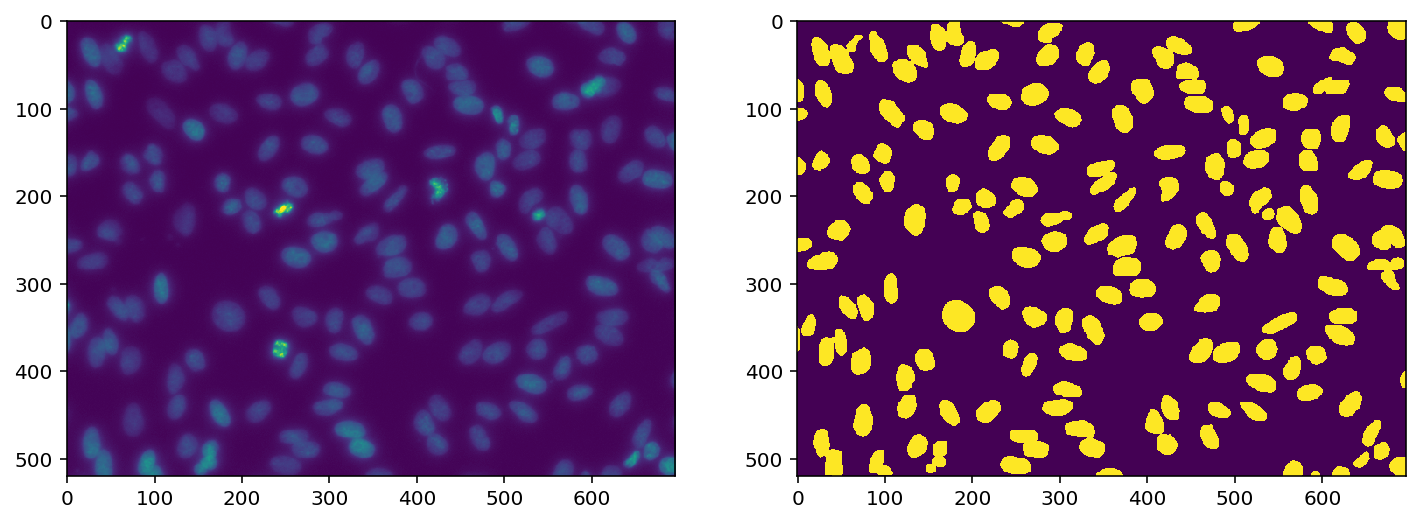

In [23]:
img = imread('data/segmentation_nuclei.tif')
gt_mask = imread('data/segmentation_mask_gt.tif')

# NOTE: in the file, foreground has value 255, bg 0 -> convert to boolean array
gt_mask = gt_mask > 0

fig, axs = plt.subplots(ncols=2)
axs[0].imshow(img)
axs[1].imshow(gt_mask)

* segment the image using thresholding and create a segmentation mask

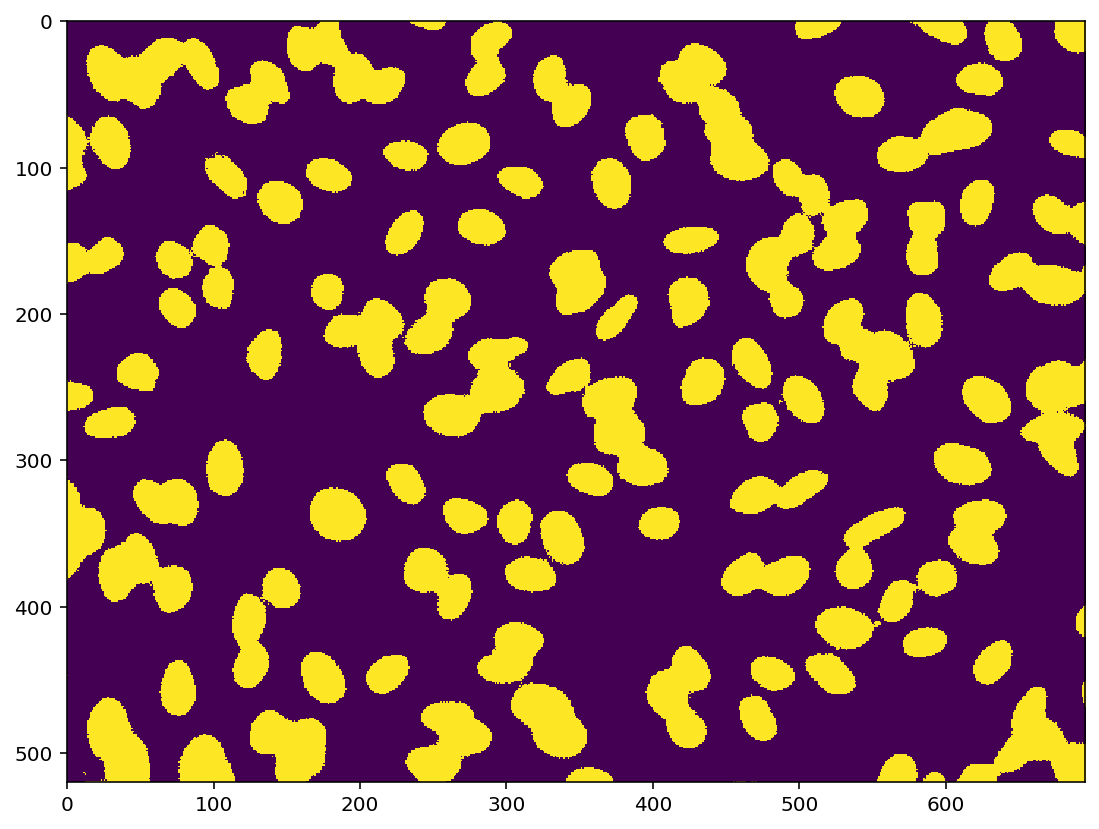

In [25]:
from skimage.filters import threshold_li


thresholded_img = img > threshold_li(img)
plt.imshow(thresholded_img)

* given the ground truth and segmentation mask, calculate the intersection of both (using binary AND)
* given the ground truth and segmentation mask, calculate the union of both (using binary OR)

73258


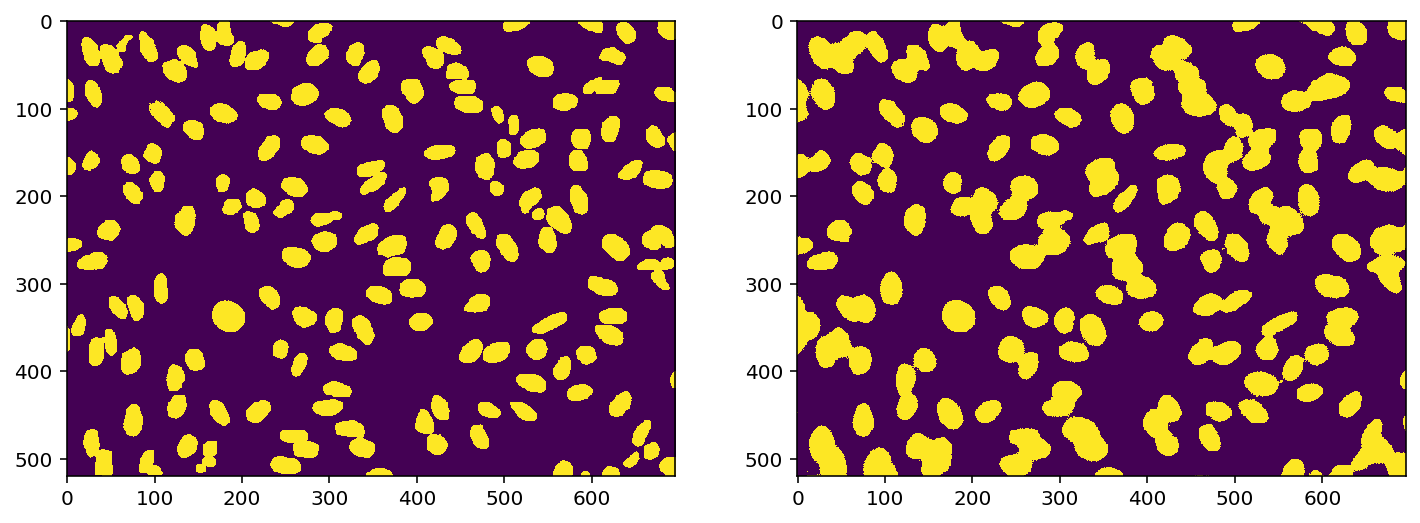

In [28]:
fig, axs = plt.subplots(ncols=2)

inter = thresholded_img & gt_mask
print(inter.sum())
axs[0].imshow(inter)

union = thresholded_img | gt_mask
print(union.sum())
axs[1].imshow(union)

* calculate the intersection-over-union (**IoU** = number of pixels in intersection divided by number of pixels in union) from the number of pixels in both masks
* **OPTIONAL:** compare different thresholding strategies
    You could:
    * apply a small amount of blur to the image before calculating the threshold
    * try different automatic threshold algorithms
    * apply some morphological operations to clean up the binary image after thresholding



In [29]:
inter.sum()/union.sum()

0.7353153731882603